In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

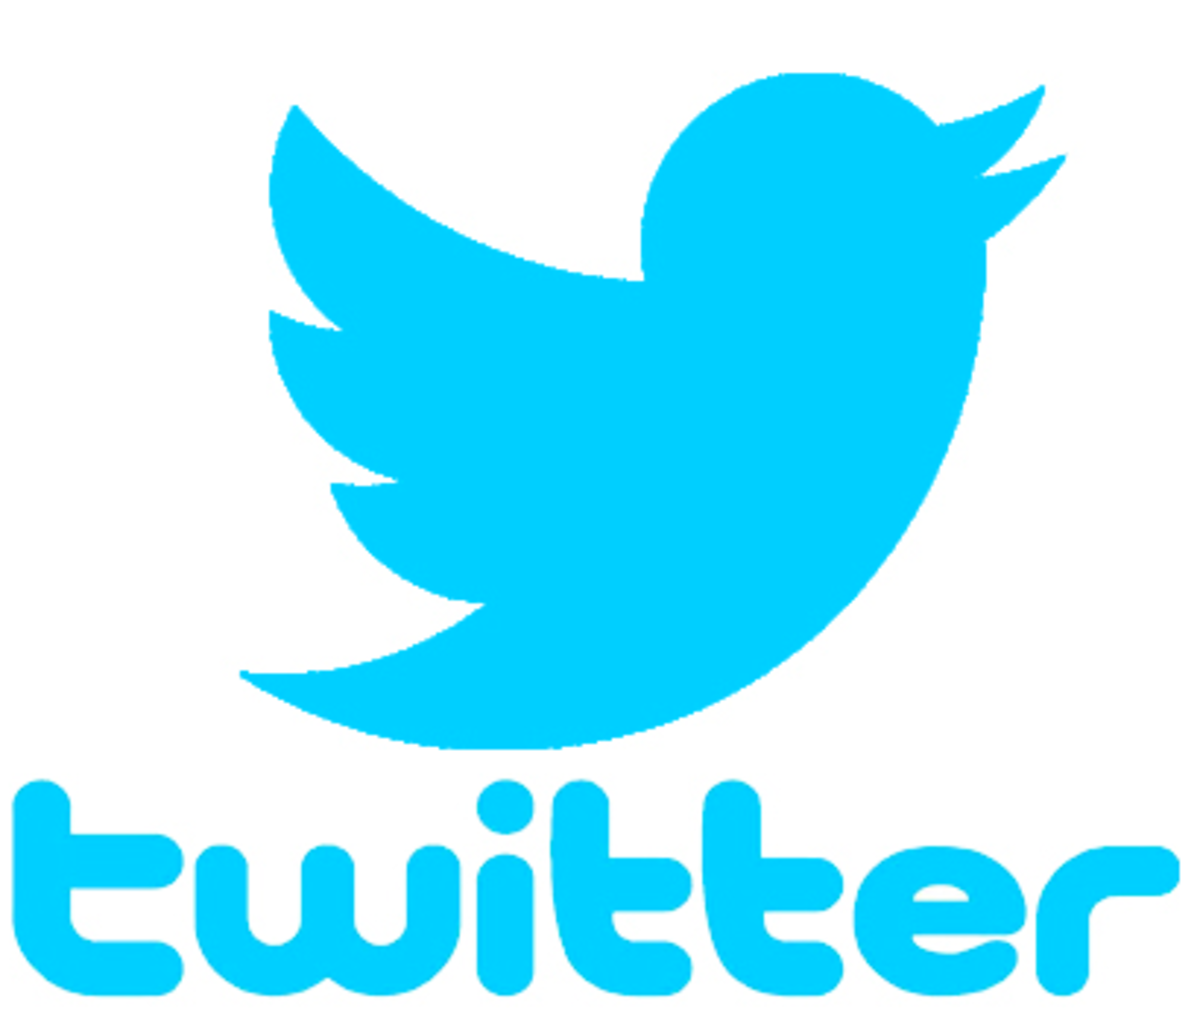

# Import Dataset

In [ ]:
train=pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv")
train.head()

In [ ]:
#Checking length of each tweet
train["length"]=train["tweet"].apply(len)

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.isnull().sum()

In [ ]:
#Dropping the id column as it is of no use
train=train.drop(["id"],axis=1)

In [ ]:
#Representing labels column as a countplot
import seaborn as sns
sns.countplot(train["label"])

In [ ]:
#Distributio for length of tweets
sns.distplot(train["length"])

# Data Preprocessing

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## Number of stopwords in each tweet

In [ ]:
stop=stopwords.words("english")

In [ ]:
#Calculating the number of stopwords in a tweet
def stop_words(df):
    df['stopwords'] = df['tweet'].apply(lambda x: len([x for x in x.split() if x in stop]))
    print(df[['tweet','stopwords']].head())

In [ ]:
stop_words(train)

# Removal of Punctuation Marks

In [ ]:
#Removing the punctuations from the tweets as they do not help in prediction
def punctuation_removal(df):
    df['tweet'] = df['tweet'].str.replace('[^\w\s]','')
    print(df['tweet'].head())

In [ ]:
punctuation_removal(train)

# Removing the most frequent words

In [ ]:
#Checking the frequency of words in all the tweets
freq = pd.Series(' '.join(train['tweet']).split()).value_counts()[:10]
freq

In [ ]:
freq = list(freq.index)

In [ ]:
#Removing the most frequent words from the dataset
def frequent_words_removal(df):  
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['tweet'].head())

In [ ]:
frequent_words_removal(train)

# Removing the rare words

In [ ]:
#Checking for rare words in the tweets
freq = pd.Series(' '.join(train['tweet']).split()).value_counts()[-10:]
freq

In [ ]:
#Removing all the rare words from the tweets
freq = list(freq.index)
def rare_words_removal(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
    print(df['tweet'].head())

In [ ]:
rare_words_removal(train)

In [ ]:
stemmer=PorterStemmer()

# Stemming and Removing Stopwords

In [ ]:
corpus=[]
for i in range(len(train)):
    #replacing everything other than alphabets with a space
    review=re.sub("[^a-zA-Z]"," ",str(train["tweet"][i]))
    #Lowering the tweets
    review=review.lower()
    #Converting in a list
    review=review.split()
    #Finding and removing stopwords
    review=[stemmer.stem(word) for word in review if not word in set(stopwords.words("english"))]
    #Joining after removal of stopwords
    review=" ".join(review)
    corpus.append(review)

In [ ]:
corpus

# Creating TFIDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv=TfidfVectorizer()
X=tfv.fit_transform(corpus).toarray()
y=train["label"]

# Splitting the Dataset into Train and Test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [ ]:
X_train.shape,y_train.shape

In [ ]:
X_test.shape,y_test.shape

# Training the Naive Bayes model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
classifier=MultinomialNB()
classifier.fit(X_train,y_train)

# Predicting results

In [ ]:
y_pred=classifier.predict(X_test)

# Checking Accuracies and Creating Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(y_pred,y_test)

In [ ]:
acc_MNB=accuracy_score(y_pred,y_test)
acc_MNB

# Predicting using LSTM 

In [ ]:
#taking dictionary size 5000
vocab_size = 5000

#one hot encoding
one_hot_dir = [one_hot(words,vocab_size) for words in corpus]

#length of all rows should be equal therefore applying padding
#this will adjust size by adding 0 at staring of the shorter rows
embedded_layer = pad_sequences(one_hot_dir,padding = 'pre')
embedded_layer

In [ ]:
#converting into numpy arrays.
X_lstm = np.array(embedded_layer)
y_lstm = np.array(y)

# Splitting the Dataset into training and test set

In [ ]:
from sklearn.model_selection import train_test_split
X_train_lstm,X_test_lstm,y_train_lstm,y_test_lstm=train_test_split(X_lstm,y_lstm,test_size=0.2,random_state=0)

# Training the LSTM model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size,64,input_length = len(X_lstm[0])))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1,activation="sigmoid"))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])
model.summary()

# Training the LSTM model

In [ ]:
model.fit(X_train_lstm, y_train_lstm, validation_data = (X_test_lstm,y_test_lstm), epochs = 5, batch_size = 32)

In [ ]:
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = (y_pred_lstm > 0.5)

# Creating Confusion Matrix and Checking Accuracy

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_lstm,y_pred_lstm)

In [ ]:
#checking accuracy
from sklearn.metrics import accuracy_score
acc_lstm=accuracy_score(y_test_lstm,y_pred_lstm)
acc_lstm

In [ ]:
z=[acc_MNB,acc_lstm]

In [ ]:
sns.countplot(z)